In [42]:
import os
import re
from scipy import stats
import tempfile
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import sys
import seaborn as sns
sys.path.append('../../CEBRA_analysis/')
from dataset_load import data_load
from scipy.stats import mannwhitneyu, normaltest, ttest_ind, levene, ttest_rel, shapiro

from sklearn.inspection import permutation_importance

In [43]:
def split_quantify_lda(x, y, animals_id, run_id, idxs):
    groups = [a+i for a, i in zip(animals_id, run_id)]
    
    rng = np.random.default_rng(seed=42)  # for reproducibility
    unique_groups = np.unique(groups)      # array of shape (55,)
    rng.shuffle(unique_groups)   
    
    
    gkf = GroupKFold(n_splits=11)
    gkf.get_n_splits(groups=groups)
    
    X_unique = np.arange(len(unique_groups))
    
    perms = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_unique, groups=unique_groups)):
    
        train_groups = unique_groups[train_idx]
        test_groups  = unique_groups[test_idx]
        
        train_mask = np.isin(groups, train_groups)
        test_mask  = np.isin(groups, test_groups)
        
        X_train, y_train = x.iloc[train_mask, idxs], y[train_mask]
        X_test,  y_test  = x.iloc[test_mask, idxs],  y[test_mask]
    
        clf = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
        clf.fit(X_train, y_train)
        perm = permutation_importance(clf, X_test, y_test, n_repeats=3, random_state=0, scoring="balanced_accuracy")
        perms.append(perm)
    return perms

In [44]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [45]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)
x = data_dict["X_pd"]
y = data_dict["y_pd"]
animals_id = data_dict["animals_id_pd"]
run_id = data_dict["run_id_pd"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [46]:
s = slice(36, None)
perms = split_quantify_lda(x, y, animals_id, run_id, idxs=s)

In [47]:
perms_importance = pd.DataFrame(index=range(0,11), columns=x.iloc[:, s].columns)

for j, r in enumerate(perms):
    for i in r.importances_mean.argsort()[::-1]:
        #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        perms_importance.loc[j, x.iloc[:, s].columns[i]] = r.importances_mean[i]

In [48]:
perms_importance

,ECOG_LEFT_RawHjorth_Activity,ECOG_LEFT_RawHjorth_Mobility,ECOG_LEFT_RawHjorth_Complexity,ECOG_RIGHT_RawHjorth_Activity,ECOG_RIGHT_RawHjorth_Mobility,ECOG_RIGHT_RawHjorth_Complexity,ECOG_LEFT_raw,ECOG_RIGHT_raw,ECOG_LEFT_bandpass_activity_low beta,ECOG_LEFT_bandpass_activity_high beta,...,coh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,coh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,coh_ECOG_RIGHT_to_ECOG_LEFT_max_allfbands_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_low beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_low beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_allfbands_high gamma
0,0.005268,-0.02248,0.096957,-0.002696,0.025042,0.016992,0.001007,-0.000164,0.00061,-0.000739,...,0.00873,0.00013,0.00081,-0.000042,-0.000042,0.000152,0.001231,0.000387,0.000608,-0.000131
1,-0.000026,-0.037224,0.045808,-0.000234,0.019803,0.010307,0.000177,-0.00028,0.000541,-0.001025,...,0.001718,0.000387,0.00099,0.000297,0.000297,-0.000081,-0.000508,-0.000514,0.003812,-0.000813
2,0.014946,-0.035607,0.070049,0.000306,0.034676,-0.030457,-0.000358,0.000416,-0.001352,0.001621,...,0.033757,0.013563,-0.002018,0.002503,0.002503,0.000153,0.000608,-0.001372,0.007321,-0.000361
3,0.024562,-0.056256,0.093479,0.004636,0.064006,0.055186,0.001167,-0.00131,-0.001599,0.003861,...,-0.042786,0.03071,-0.003869,0.00535,0.00535,0.000443,0.003313,-0.005743,0.022799,-0.00107
4,0.020259,-0.030252,0.103692,-0.001518,0.030708,0.01594,0.000251,0.000131,0.000054,-0.000067,...,0.011282,0.004698,0.002859,-0.000068,-0.000068,0.000727,-0.000371,0.001609,0.01028,0.000548
5,0.008008,-0.002253,0.085798,0.0016,-0.008729,0.027153,-0.000315,0.000173,-0.0001,0.001878,...,0.006868,0.010949,-0.000609,0.000166,0.000166,-0.000004,0.003083,0.000203,0.006459,-0.000895
6,-0.026771,0.017065,0.024679,-0.001738,-0.029821,0.005347,-0.000677,-0.000488,-0.000609,-0.000596,...,0.017956,-0.007982,-0.000744,-0.000542,-0.000542,-0.000116,-0.000352,0.000125,-0.002948,0.000677
7,-0.001865,0.020003,0.029594,-0.002197,-0.009211,-0.019053,-0.000799,-0.000267,0.000015,-0.000739,...,0.003357,0.003243,-0.002559,-0.000388,-0.000388,-0.001224,0.000744,0.005014,-0.001208,-0.001148
8,0.02562,-0.040173,0.081858,0.000642,0.040472,-0.003575,-0.000447,0.000022,-0.001182,0.00097,...,0.040774,-0.000971,0.001688,-0.000821,-0.000821,-0.000343,-0.000744,0.000823,0.002897,0.00007
9,-0.002772,-0.136512,0.080523,-0.000565,0.017051,0.00256,-0.000105,-0.000076,0.000311,-0.000077,...,-0.018096,0.005442,0.001065,0.000469,0.000469,-0.000401,-0.00069,0.000656,0.006353,-0.000371


In [49]:
perms_importance_avg = perms_importance.mean(axis=0)

sort_idx = np.argsort(perms_importance_avg)[::-1]
sorted_cols = perms_importance.columns[sort_idx]

perms_importance = perms_importance.loc[:, sorted_cols]

In [50]:
perms_importance

,ECOG_LEFT_RawHjorth_Complexity,ECOG_RIGHT_fft_high gamma,ECOG_LEFT_fft_high beta,ECOG_LEFT_stft_high beta,ECOG_RIGHT_RawHjorth_Mobility,ECOG_RIGHT_bursts_low gamma_amplitude_mean,ECOG_LEFT_fft_high gamma,ECOG_LEFT_fft_HFA,ECOG_LEFT_stft_high gamma,ECOG_RIGHT_RawHjorth_Complexity,...,coh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,ECOG_RIGHT_fft_high beta,ECOG_RIGHT_bursts_low gamma_amplitude_max,ECOG_LEFT_bursts_high gamma_amplitude_max,ECOG_LEFT_Sharpwave_Max_prominence_range_5_80,ECOG_LEFT_Sharpwave_Mean_interval_range_5_80,ECOG_RIGHT_stft_HFA,ECOG_RIGHT_fft_HFA,ECOG_RIGHT_stft_high gamma,ECOG_LEFT_RawHjorth_Mobility
0,0.096957,0.02314,0.065702,0.070456,0.025042,0.001724,0.008357,0.008171,0.002166,0.016992,...,0.006928,-0.01554,0.000777,0.003255,-0.012146,-0.00368,0.001688,0.023446,0.001021,-0.02248
1,0.045808,0.02564,0.033335,0.03293,0.019803,0.004241,0.022673,0.014265,0.015656,0.010307,...,0.004541,-0.007861,-0.000769,-0.009617,-0.006668,-0.007233,-0.009315,-0.026616,-0.001809,-0.037224
2,0.070049,0.045178,0.02032,0.007836,0.034676,0.027323,0.008399,0.00985,0.00177,-0.030457,...,-0.022851,0.008839,-0.015475,-0.002322,-0.007452,-0.00323,-0.048048,-0.086486,-0.063301,-0.035607
3,0.093479,0.156914,-0.00223,-0.022277,0.064006,0.090988,0.019084,0.01069,0.011246,0.055186,...,-0.021825,0.015825,-0.006425,-0.001467,0.015352,0.006394,-0.006487,-0.120746,-0.017789,-0.056256
4,0.103692,0.059476,0.043927,0.028528,0.030708,0.012758,0.03923,0.013879,0.032778,0.01594,...,-0.001156,-0.005279,-0.000209,-0.010205,-0.01645,-0.010322,-0.014224,-0.024028,-0.01927,-0.030252
5,0.085798,0.07948,0.024124,0.014269,-0.008729,-0.002539,0.014527,0.005391,0.01253,0.027153,...,0.00145,-0.008302,0.001976,0.000257,-0.001833,-0.007066,0.013687,0.048606,0.010859,-0.002253
6,0.024679,-0.003019,0.026016,0.022663,-0.029821,-0.016553,-0.004963,0.024329,-0.004178,0.005347,...,0.013425,-0.00278,0.003598,-0.005031,-0.005044,-0.009188,0.007787,0.066331,-0.001082,0.017065
7,0.029594,0.044809,0.03564,0.01789,-0.009211,0.016099,-0.001417,0.011248,0.003848,-0.019053,...,-0.005696,0.020449,-0.002795,0.003893,-0.017443,-0.004463,-0.001586,-0.009867,-0.004803,0.020003
8,0.081858,0.03514,0.029172,0.006115,0.040472,0.017126,0.016667,0.036468,0.033937,-0.003575,...,0.002531,-0.005663,-0.005026,-0.010973,0.015029,-0.007047,-0.021669,-0.029382,-0.052293,-0.040173
9,0.080523,0.039335,0.029173,0.038181,0.017051,0.002285,0.025893,-0.008278,0.013369,0.00256,...,-0.008579,-0.027052,-0.00572,-0.00629,-0.031054,-0.022364,-0.010346,-0.037758,-0.017143,-0.136512


In [51]:
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(perms_importance.iloc[:, :feats_n].columns, feats_cmap)}

In [52]:
perms_importance.iloc[:, :feats_n].columns

Index(['ECOG_LEFT_RawHjorth_Complexity', 'ECOG_RIGHT_fft_high gamma',
       'ECOG_LEFT_fft_high beta', 'ECOG_LEFT_stft_high beta',
       'ECOG_RIGHT_RawHjorth_Mobility'],
      dtype='object')

In [53]:
cmap_d

{'ECOG_LEFT_RawHjorth_Complexity': array([0.64959573, 0.74985201, 0.79400674, 1.        ]),
 'ECOG_RIGHT_fft_high gamma': array([0.37431313, 0.39503895, 0.71098797, 1.        ]),
 'ECOG_LEFT_fft_high beta': array([0.23433056, 0.0669356 , 0.2957401 , 1.        ]),
 'ECOG_LEFT_stft_high beta': array([0.49335504, 0.13328092, 0.31386562, 1.        ]),
 'ECOG_RIGHT_RawHjorth_Mobility': array([0.76822177, 0.50649362, 0.40061257, 1.        ])}

[-0.05  0.05  0.15]


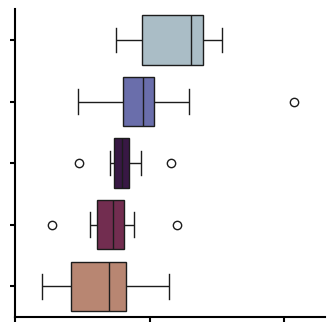

In [54]:
fig, ax = plt.subplots(figsize=(4,4))

sns.boxplot(perms_importance.iloc[:, :feats_n], orient="h", ax=ax, palette= cmap_d)

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)
print(ax.get_xticks())
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

ax.set_xlim(-0.05, 0.18)

plt.savefig("lda_boxplot_neural.png", transparent=True)
plt.savefig("lda_boxplot_neural.svg", transparent=True)

In [55]:
s = slice(36, None)
x_fit=x.iloc[:, s]
clf = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
clf.fit(x_fit, y)
prediction = clf.predict(x_fit)

df_scalings = pd.DataFrame(clf.scalings_, columns=["x", "y"])
df_scalings["magn"] = np.sqrt(df_scalings["x"]**2 + df_scalings["y"]**2)
df_scalings["feats"] = x_fit.columns

x [-10.  -6.  -2.   2.   6.]
y [-12.5  -7.5  -2.5   2.5   7.5]


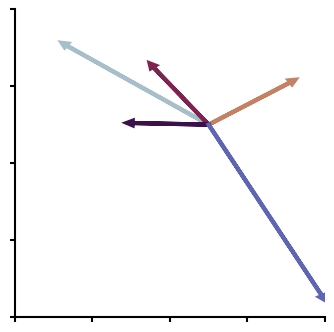

In [56]:
x_trans = clf.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))

colors = ["black", "lightgray", "slategray"]
colors = ["cyan", "#2e2d4d", "m"]
#for color, i, target_name in zip(colors, [0, 1, 2], y):
#    sc=ax.scatter(x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2)

feats = perms_importance.iloc[:, :feats_n].columns
magns = df_scalings[df_scalings["feats"].isin(feats)][["x", "y", "feats"]].values

for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], color=cmap_d[val[2]], head_width=0.3, head_length=0.3)

#sc.set_rasterized(True)
#plt.legend(loc=[1,0])
ax.set_xlim(-9, 5)
ax.set_ylim(-11, 7.5)
#ax.set_ylim(-10, 7.5)
print("x", ax.get_xticks()[::2])
print( "y", ax.get_yticks()[::2])

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )

#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_neural_arrows_only_.png", transparent=True, dpi=100)
plt.savefig("lda_neural_arrows_only_.svg", transparent=True)

x [-6. -2.  2.  6.]
y [-8. -4.  0.  4.  8.]


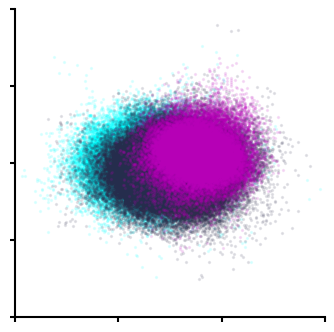

In [57]:
x_trans = clf.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))

colors = ["black", "lightgray", "slategray"]
colors = ["cyan", "#2e2d4d", "m"]
for color, i, target_name in zip(colors, [0, 1, 2], y):
    sc=ax.scatter(x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2)

feats = perms_importance.iloc[:, :feats_n].columns
magns = df_scalings[df_scalings["feats"].isin(feats)][["x", "y", "feats"]].values

for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], color=cmap_d[val[2]], head_width=0.3, head_length=0.3, alpha=0)

sc.set_rasterized(True)
#plt.legend(loc=[1,0])
ax.set_xlim(-6, 5)
ax.set_ylim(-7.5, 7.5)
print("x", ax.get_xticks()[::2])
print( "y", ax.get_yticks()[::2])

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )

#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_neural_scatter_only_.png", transparent=True, dpi=300)

In [58]:
colors = ["cyan", "#2e2d4d", "m"]
vals = [0, 1, 2]  # Discretizes the interpolation into bins
cmap_neurokin_d = {k: v for k, v in zip(vals, colors)}

In [59]:
data = pd.DataFrame(x_trans, columns=["PC1", "PC2"])
data["label"] = y

In [60]:
colors = ["cyan", "#2e2d4d", "m"]
vals = [0, 1, 2]  # Discretizes the interpolation into bins
cmap_neurokin_d = {k: v for k, v in zip(vals, colors)}

In [65]:
f = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

x [-6 -2  2  6]
y [-6 -2  2  6  8]


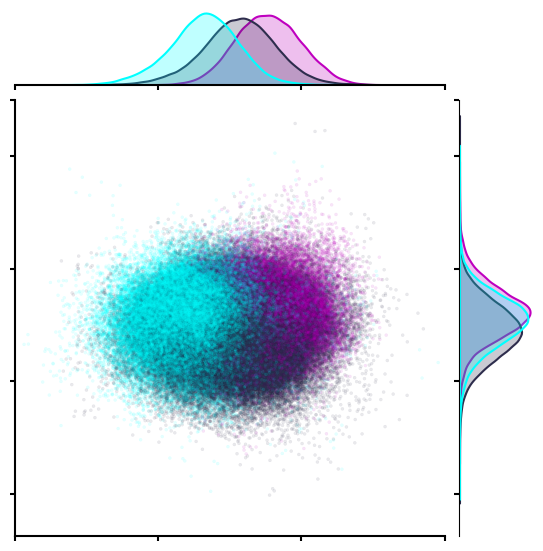

In [69]:
jp = sns.jointplot(data=data, x="PC1", y="PC2", hue="label", palette=cmap_neurokin_d, s=5, edgecolor=None, alpha=0.1, marginal_kws={'linewidth': 1.5, "common_norm": False}, hue_norm=f)

jp.ax_marg_x.spines[['bottom']].set_linewidth(1.5)
jp.ax_marg_y.spines[['bottom']].set_linewidth(1.5)
jp.ax_marg_x.tick_params(width=1.5)
jp.ax_marg_y.tick_params(width=1.5)

ax = jp.ax_joint

for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], alpha=0, color=cmap_d[val[2]], head_width=0.3, head_length=0.3)

plt.legend([],[], frameon=False)
ax.set_xlim(-6, 5)
ax.set_ylim(-7.5, 7.5)


ax.set_xticks(ticks=[-6, -2, 2, 6], labels=[] )
ax.set_yticks(ticks=[-6, -2, 2, 6, 8], labels=[] )
print("x", ax.get_xticks())
print( "y", ax.get_yticks())

#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_neural_scatter_density.png", transparent=True, dpi=300)
plt.savefig("lda_neural_scatter_density.svg", transparent=True, dpi=300)

# Kinematics 

In [21]:
s_kin = slice(None, 36)
perms_kin = split_quantify_lda(x, y, animals_id, run_id, idxs=s_kin)

perms_importance_kin = pd.DataFrame(index=range(0,12), columns=x.iloc[:, s_kin].columns)

for j, r in enumerate(perms_kin):
    for i in r.importances_mean.argsort()[::-1]:
        #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        perms_importance_kin.loc[j, x.iloc[:, s_kin].columns[i]] = r.importances_mean[i]

In [22]:
perms_importance_avg_kin = perms_importance_kin.mean(axis=0)

sort_idx_kin = np.argsort(perms_importance_avg_kin)[::-1]
sorted_cols_kin = perms_importance_kin.columns[sort_idx_kin]

perms_importance_kin = perms_importance_kin.loc[:, sorted_cols_kin]

In [23]:
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(perms_importance_kin.iloc[:, :feats_n].columns, feats_cmap)}

In [24]:
cmap_d

{'rshoulder_speed_mean': array([0.64959573, 0.74985201, 0.79400674, 1.        ]),
 'lshoulder_speed_mean': array([0.37431313, 0.39503895, 0.71098797, 1.        ]),
 'rcrest_speed_mean': array([0.23433056, 0.0669356 , 0.2957401 , 1.        ]),
 'rhip_speed_mean': array([0.49335504, 0.13328092, 0.31386562, 1.        ]),
 'rknee_speed_mean': array([0.76822177, 0.50649362, 0.40061257, 1.        ])}

In [25]:
perms_importance_kin.iloc[:, :feats_n].columns

Index(['rshoulder_speed_mean', 'lshoulder_speed_mean', 'rcrest_speed_mean',
       'rhip_speed_mean', 'rknee_speed_mean'],
      dtype='object')

[-0.04  0.    0.04  0.08]


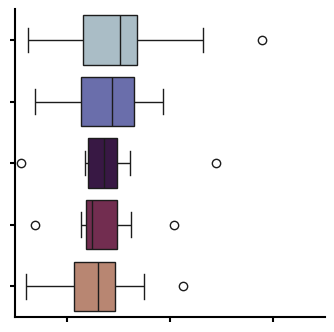

In [26]:
fig, ax = plt.subplots(figsize=(4,4))
cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))
sns.boxplot(perms_importance_kin.iloc[:, :feats_n], orient="h", ax=ax, palette=cmap_d)
print(ax.get_xticks()[::2])
ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)

ax.set_xlim(-0.02, 0.10)

ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_boxplot_kin.png", transparent=True)
plt.savefig("lda_boxplot_kin.svg", transparent=True)

In [27]:
s_kin = slice(None, 36)
x_fit=x.iloc[:, s_kin]
clf_kin = LinearDiscriminantAnalysis(store_covariance=True, n_components=2)
clf_kin.fit(x_fit, y)
prediction_kin = clf_kin.predict(x_fit)

df_scalings_kin = pd.DataFrame(clf_kin.scalings_, columns=["x", "y"])
df_scalings_kin["magn"] = np.sqrt(df_scalings_kin["x"]**2 + df_scalings_kin["y"]**2)
df_scalings_kin["feats"] = x_fit.columns

x [-6. -2.  2.  6.]
y [-6. -2.  2.  6.]


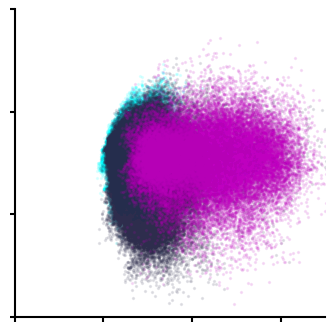

In [28]:
x_trans = clf_kin.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))

cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))

colors = ["black", "lightgray", "slategray"]
colors = ["cyan", "#2e2d4d", "m"]
for color, i, target_name in zip(colors, [0, 1, 2], y):
    sc=ax.scatter(
        x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2
    )

feats = perms_importance_kin.iloc[:, :feats_n].columns
magns = df_scalings_kin[df_scalings_kin["feats"].isin(feats)][["x", "y", "feats"]].values
for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], alpha=0, color=cmap_d[val[2]], head_width=0.3, head_length=0.3)

sc.set_rasterized(True)
#plt.legend(loc=[1,0])
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 8)
print("x", ax.get_xticks()[::2])
print( "y", ax.get_yticks()[::2])
ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )


#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

#plt.savefig("lda_kinematic_scatter_only_.svg", transparent=True, dpi=10)
plt.savefig("lda_kinematic_scatter_only_.png", transparent=True, dpi=300)

x [-6. -2.  2.  6.]
y [-6. -2.  2.  6.]


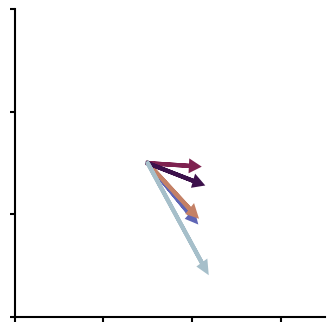

In [29]:
x_trans = clf_kin.transform(x_fit)
fig, ax = plt.subplots(figsize=(4,4))

cmap = plt.get_cmap('twilight')
cmap = cmap(np.linspace(0.1, 1, 6))

colors = ["black", "lightgray", "slategray"]
colors = ["cyan", "#2e2d4d", "m"]
#for color, i, target_name in zip(colors, [0, 1, 2], y):
#    sc=ax.scatter(
#        x_trans[y == i, 0], x_trans[y == i, 1], alpha=0.1, color=color, label=i, s=2
#    )
#
feats = perms_importance_kin.iloc[:, :feats_n].columns
magns = df_scalings_kin[df_scalings_kin["feats"].isin(feats)][["x", "y", "feats"]].values

for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], alpha=1, color=cmap_d[val[2]], head_width=0.3, head_length=0.3)
sc.set_rasterized(True)
#plt.legend(loc=[1,0])
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 8)
print("x", ax.get_xticks()[::2])
print( "y", ax.get_yticks()[::2])
ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )


#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_kinematic_arrows_only_.png", transparent=True)
plt.savefig("lda_kinematic_arrows_only_.svg", transparent=True)

In [30]:
data = pd.DataFrame(x_trans, columns=["PC1", "PC2"])
data["label"] = y

x [-6. -2.  2.  6.]
y [-6. -2.  2.  6.]


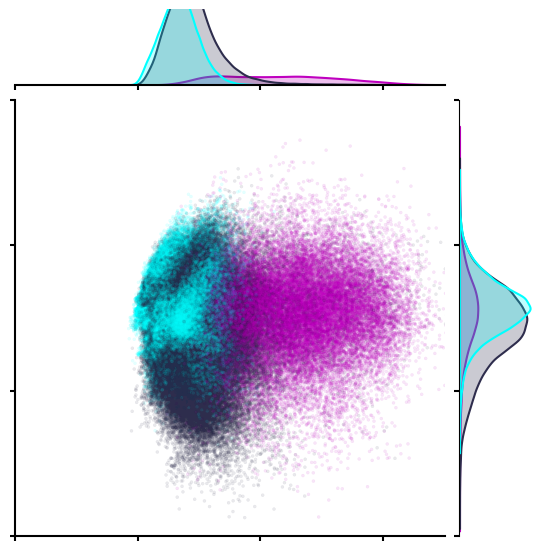

In [31]:
jp = sns.jointplot(data=data, x="PC1", y="PC2", hue="label", palette=cmap_neurokin_d, s=5, edgecolor=None, alpha=0.1, xlim=(-9,5), marginal_kws={'linewidth': 1.5})

jp.ax_marg_x.spines[['bottom']].set_linewidth(1.5)
jp.ax_marg_y.spines[['bottom']].set_linewidth(1.5)
jp.ax_marg_x.set_ylim(0,0.2)

jp.ax_marg_x.tick_params(width=1.5)
jp.ax_marg_y.tick_params(width=1.5)

ax = jp.ax_joint

for i, val in enumerate(magns):
    ax.arrow(0, 0, val[0]*10, val[1]*10, linewidth=3, label=val[2], alpha=0, color=cmap_d[val[2]], head_width=0.3, head_length=0.3)

plt.legend([],[], frameon=False)
ax.set_ylim(-5, 5)
ax.set_xlim(-5, 8)
print("x", ax.get_xticks()[::2])
print( "y", ax.get_yticks()[::2])

ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[] )
ax.set_yticks(ticks=ax.get_yticks()[::2], labels=[] )

#labels=[])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("lda_kinematics_scatter_density.png", transparent=True, dpi=100)
#plt.savefig("lda_kinematics_scatter_density.svg", transparent=True, dpi=100)

## Correlation analysis

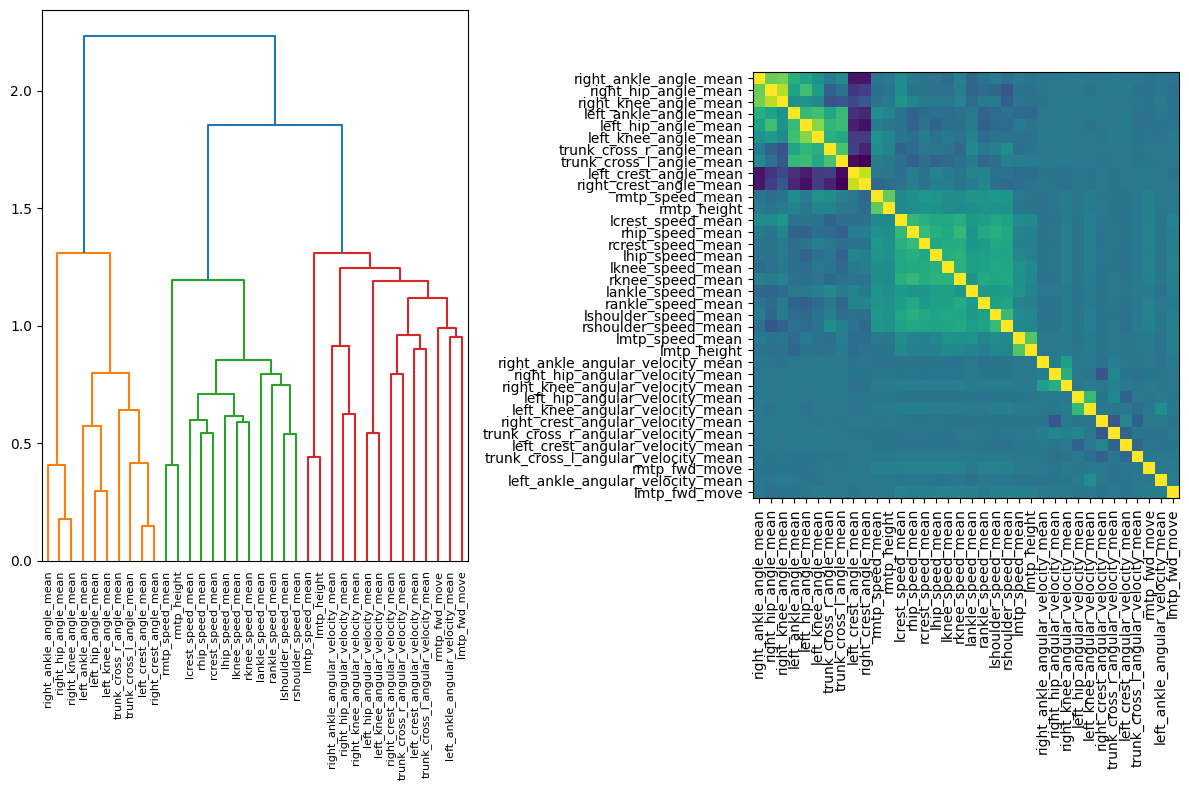

In [32]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

s = slice(None, 36)
X = x.iloc[:, s]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

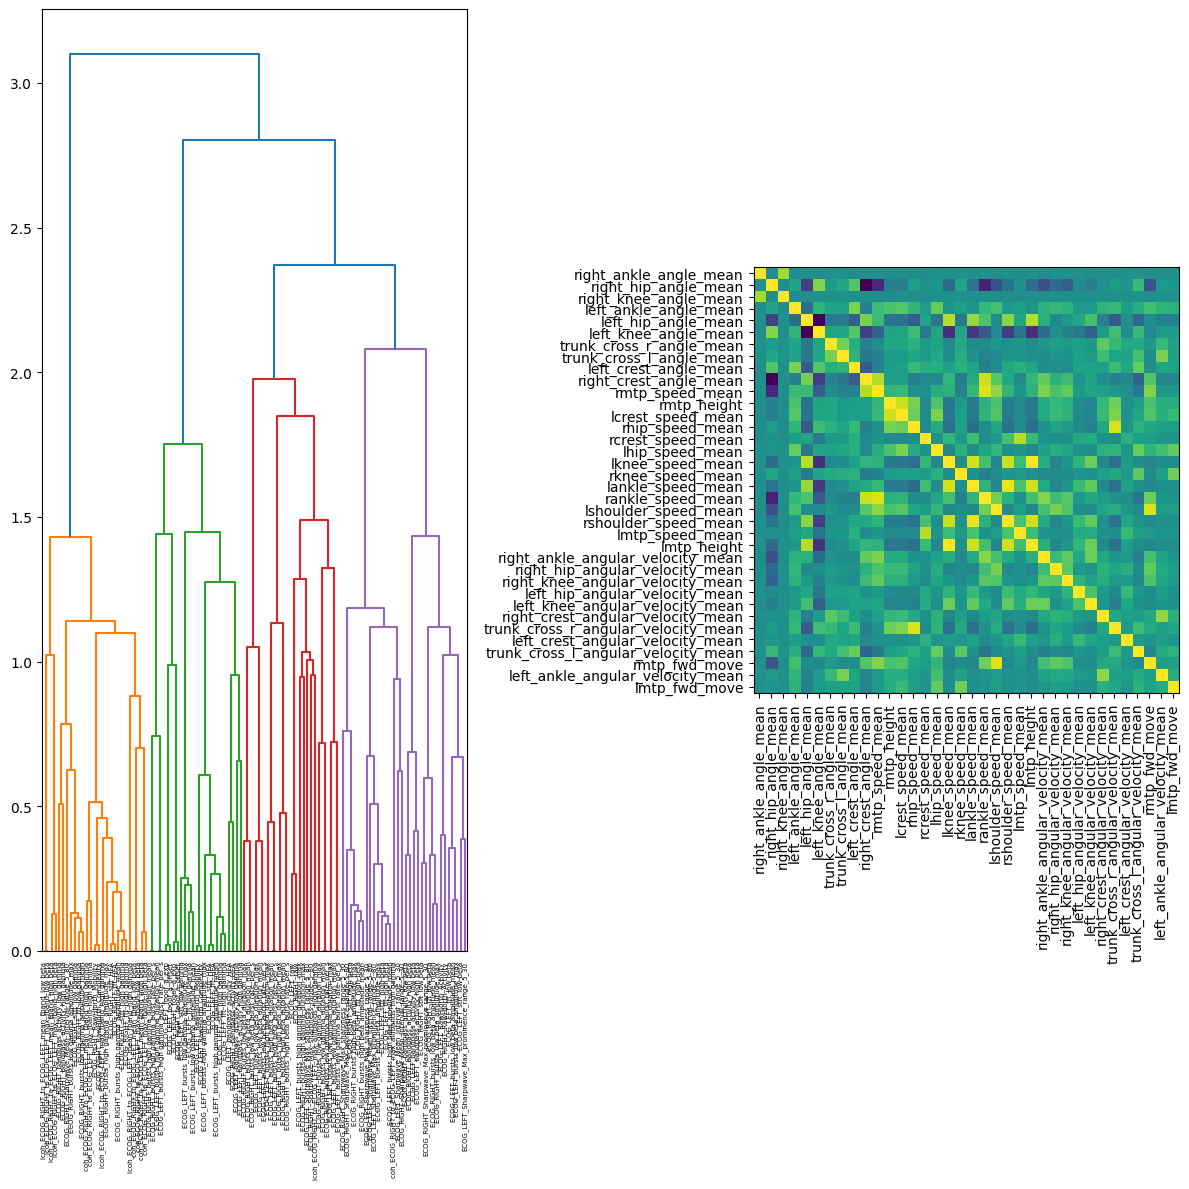

In [33]:
s = slice(36, None)
X = x.iloc[:, s]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
ùdendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()